### K-Means use case
1. General approach with sklearn
2. Elbow-diagramm for best-k choice
3. Silouette-diagramm for best k-choice (TODO)
4. Analysis and Explanation of the model
5. Improvement suggestions


Dataset used: http://archive.ics.uci.edu/ml

In [1]:
import pandas as pd
import sklearn
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
# Data preparation
raw_df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")  # use your data instead of the url
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Retail dataset
# drop all null rows
raw_df = raw_df.dropna()

# drop not needed stuff 
raw_df.drop(columns=['StockCode', 'Description'], inplace=True)

# datetime str into datetime obj
# raw_df['InvoiceDate'] = raw_df['InvoiceDate'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
raw_df['Quantity'] = raw_df['Quantity'].apply(lambda x: int(x))
raw_df['CustomerID'] = raw_df['CustomerID'].apply(lambda x: int(x))
raw_df['UnitPrice'] = raw_df['UnitPrice'].apply(lambda x: float(x))
raw_df = raw_df.drop(raw_df[raw_df.Quantity <= 0].index)
raw_df['Transaction'] = raw_df["UnitPrice"] * raw_df["Quantity"]
origin = raw_df.copy()


In [5]:
raw_df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction
0,536365,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [6]:
# create RFM for the whole time
lastDate = raw_df['InvoiceDate'].iloc[-1]
raw_df = raw_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (lastDate - x.max()).days, 
                                           'InvoiceNo': lambda x: len(x), 
                                           'Transaction': lambda x: x.sum()})
raw_df['InvoiceDate'] = raw_df['InvoiceDate'].astype(int)
raw_df.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Transaction': 'monetary'}, inplace=True)

raw_df.head()

,recency,frequency,monetary
CustomerID,,,
12346,325,1,77183.60
12347,1,182,4310.00
12348,74,31,1797.24
12349,18,73,1757.55
12350,309,17,334.40


In [7]:
from sklearn.preprocessing import StandardScaler

def scale(df):
    ss = StandardScaler()
    return pd.DataFrame(ss.fit_transform(df[['recency', 'frequency', 'monetary']]), columns=['res', 'freq', 'mon'])

    
X = scale(raw_df)
X.head()

/home/alisa/projects/ml-showcase/env/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alisa/projects/ml-showcase/env/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,res,freq,mon
0,2.334858,-0.396512,8.359634
1,-0.905199,0.394688,0.251046
2,-0.175186,-0.265374,-0.028546
3,-0.735196,-0.081781,-0.032963
4,2.174855,-0.326572,-0.191315


Text(0, 0.5, 'inertia')

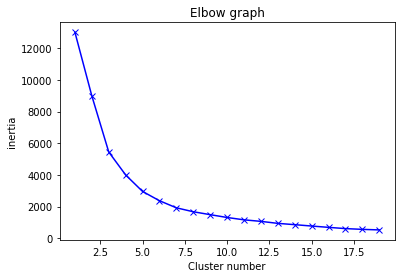

In [8]:
# We only want to see what K-Means can show us based on different set of data
from sklearn.cluster import KMeans

distortion = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(X)
    distortion.append(kmeans.inertia_)
    
plt.plot(range(1,20), distortion, 'bx-')
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('inertia')

# 6 or 7 clusters seems to be fine

In [9]:
K = 4
final_model = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(X)
raw_df['clusters'] = final_model.predict(X)
clusters_x = [i[0] for i in final_model.cluster_centers_]
clusters_y = [i[1] for i in final_model.cluster_centers_]
clusters_z = [i[2] for i in final_model.cluster_centers_]

raw_df.head()

,recency,frequency,monetary,clusters
CustomerID,,,,
12346,325,1,77183.60,0
12347,1,182,4310.00,1
12348,74,31,1797.24,1
12349,18,73,1757.55,1
12350,309,17,334.40,0


In [10]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=raw_df.recency,
    y=raw_df.frequency,
    z=raw_df.monetary,
    mode='markers',
    marker=dict(
        size=4,
        color='rgb(127, 127, 127)',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    x=clusters_x,
    y=clusters_y,
    z=clusters_z,
    mode='markers',
    marker=dict(
        size=4,
        color='red',                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)


data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Text(0.5, 0, 'Monetary')

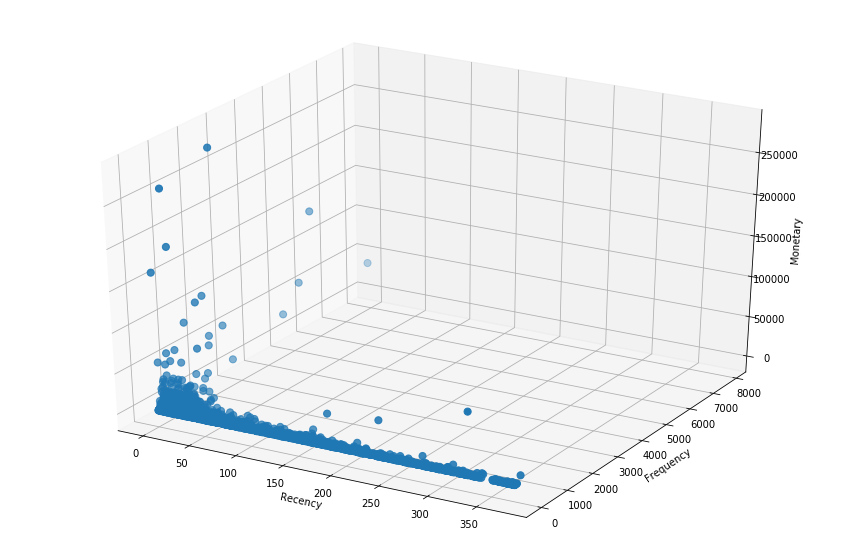

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(raw_df.recency, raw_df.frequency, raw_df.monetary, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

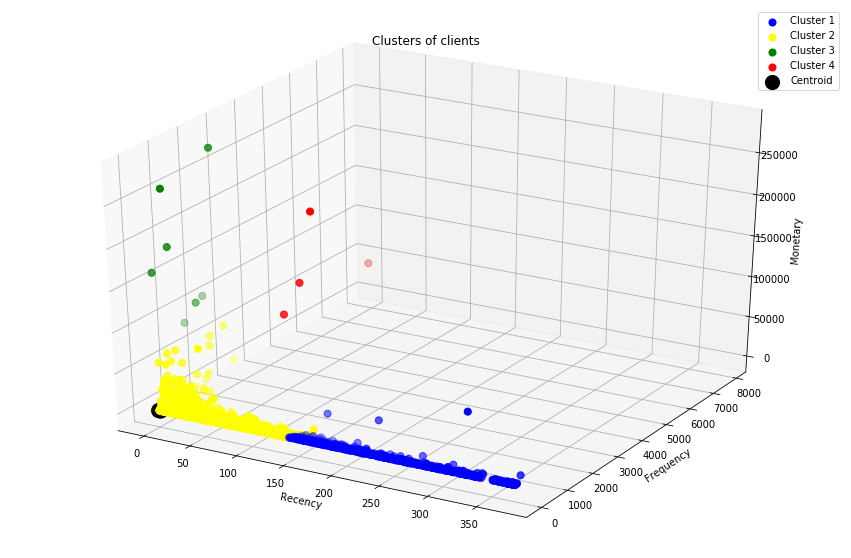

In [12]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red', 'orange', 'purple', 'pink']

for i in range(0,K):
    dx.scatter(raw_df[raw_df.clusters == i].recency, 
               raw_df[raw_df.clusters == i].frequency, 
               raw_df[raw_df.clusters == i].monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.scatter(clusters_x, clusters_y, clusters_z, c="black", label="Centroid", s=200)
dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

In [ ]:
def prepare_clustered_data(column1, column2):
    for i in range(K):
        cl = raw_df[raw_df.clusters == i]
        plt.scatter(cl[column1], cl[column2], c=colors[i], label='Cluster {}'.format(i))
    plt.scatter(clusters_x, clusters_y, c="black", label='Centroids')

    plt.title('Clusters of clients')
    plt.xlabel('{}'.format(column1))
    plt.ylabel('{}'.format(column2))
    plt.legend()
    
prepare_clustered_data('recency', 'monetary')

In [14]:
# Compute CLV for each cluster: average in the cluster as a prediction for a newcomer
def dumb_forecast():
    avg_cluster_clv = {}
    for i in range(K):
        avg_cluster_clv[i] = raw_df[raw_df['clusters'] == i]['monetary'].mean()
    return avg_cluster_clv

expected_clv = dumb_forecast()
print(expected_clv)


{0: 637.3185101851851, 1: 2063.7806690270936, 2: 176606.16428571427, 3: 70925.2875}


In [16]:
# Supposed usage
# 1. persist model
from joblib import dump, load
persistent_model = dump(final_model, '../models/k-means-test.joblib')
persistent_model = None  # to fake storing the model externally

# reading out in job/service initialization
loaded_model = load('../models/k-means-test.joblib')

# comparing that 2 same models
new_user_99999 = pd.DataFrame.from_dict({"recency": [1], "frequency": [114], "monetary": [1356.8787]})

# exsiting in-memory model
new_user_99999_cluster_memory = final_model.predict(new_user_99999)

# saved and read-out model
new_user_99999_cluster_read = loaded_model.predict(new_user_99999)


print("Clusters identified: ")
print("Memory class {} vs load class {}".format(new_user_99999_cluster_memory[0], 
                                                new_user_99999_cluster_read[0]))
print("____________________\n")
print("Expected CLV for this class: ")
print("Memory class {} vs load class {}".format(expected_clv[new_user_99999_cluster_memory[0]],
                                               expected_clv[new_user_99999_cluster_read[0]]))


Clusters identified: 
Memory class 2 vs load class 2
____________________

Expected CLV for this class: 
Memory class 176606.16428571427 vs load class 176606.16428571427


### How to improve clustering?
1. Additionall behavioural features -> probably will need PCA for interpritability
2. Different algorithms: Ward, GaussianMixture, SpectralClustering, etc. 
3. Make data behave: clusters are convex and isotropic, prepared scaling

### How to forecast?
1. Dumb weighted average for the cluster
2. Regressions
3. Tree-Based
4. Boosting

### How to explain?
1. LIMA
2. SHAP